# UMAP

going to try this with kmeans

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cluster_utils as cu
import db_utils as db
import os
import pandas as pd
import importlib

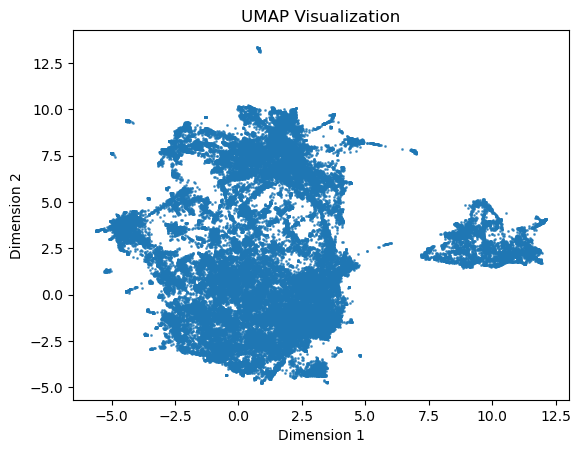

In [2]:
# get folder outside current directory (project folder)
current_dir = os.path.dirname(os.getcwd())
proj_dir = os.path.abspath(os.path.join(current_dir, '..'))

# Load the 2D coordinates
coordinates = np.load(proj_dir + "/dataset/pubmed_20241121_working_memory.embd.umap.npy")

# Scatter plot
plt.scatter(coordinates[:, 0], coordinates[:, 1], s=1, alpha=0.7)
plt.title("UMAP Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


In [3]:
coordinates.shape

(73763, 2)

## Clustering

### hdbscan

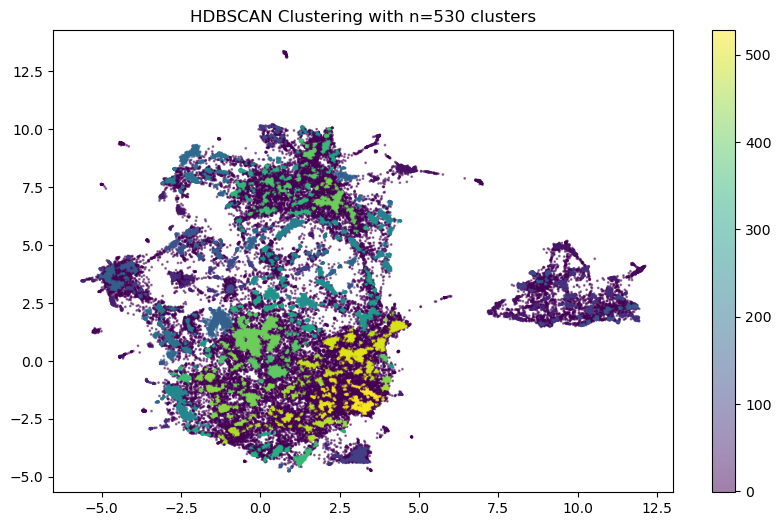

In [4]:
importlib.reload(cu)
hdbscan_labels = cu.hdbscan_cluster(coordinates, min_cluster_size=10, gen_min_span_tree=True, plot=1)

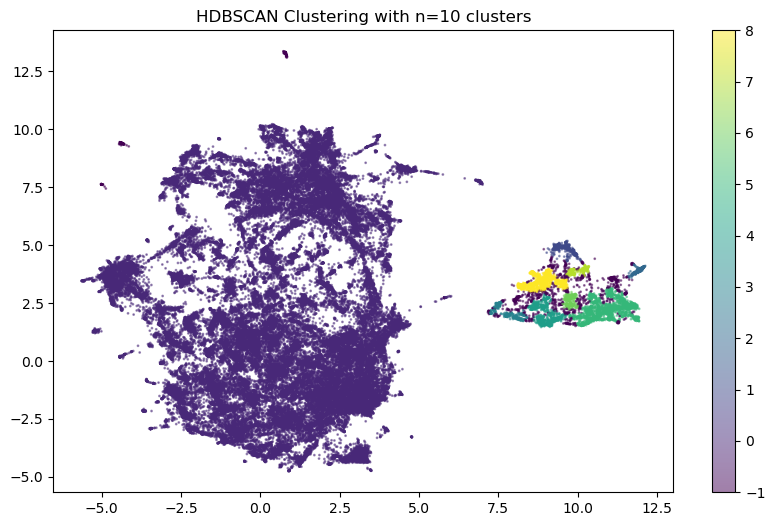

In [5]:
importlib.reload(cu)
hdbscan_labels = cu.hdbscan_cluster(coordinates, 
                                    min_cluster_size=250, min_samples=50, 
                                    gen_min_span_tree=True, plot=1)

In [13]:
min_samples

array([ 10,  30,  50,  70,  90, 110, 130, 150, 170, 190, 210, 230, 250,
       270, 290, 310, 330, 350, 370, 390, 410, 430, 450, 470, 490, 510,
       530, 550, 570, 590, 610, 630, 650, 670, 690, 710, 730, 750, 770,
       790, 810, 830, 850, 870, 890, 910, 930, 950, 970, 990])

10


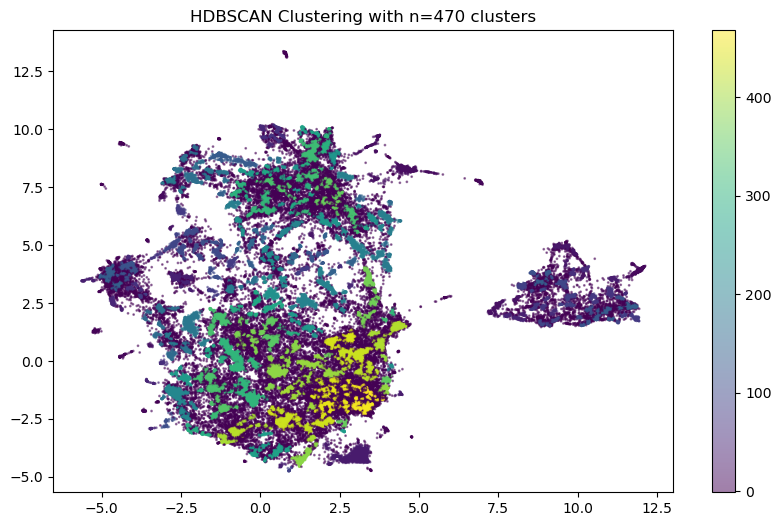

20


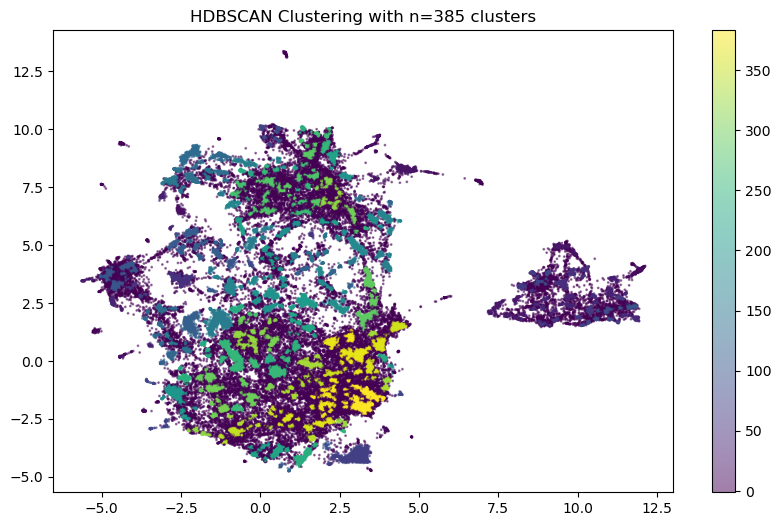

30


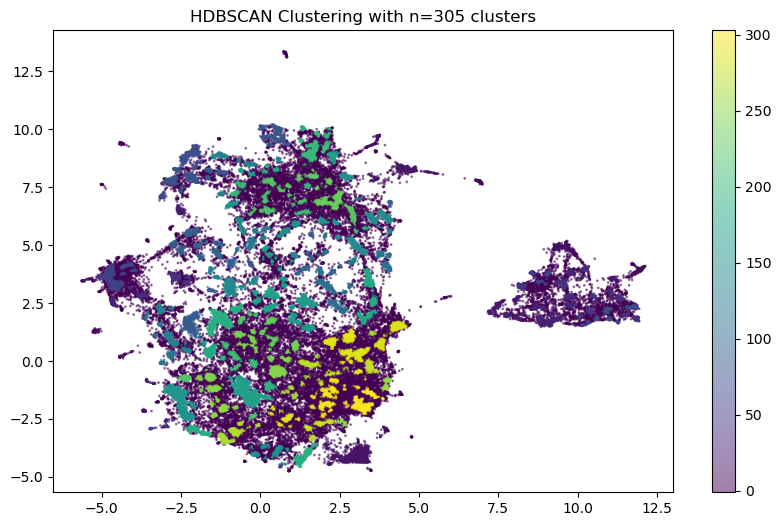

40


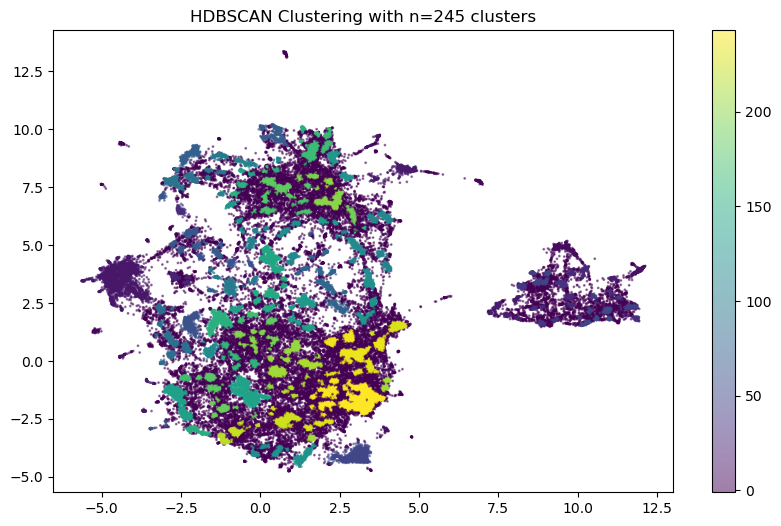

50


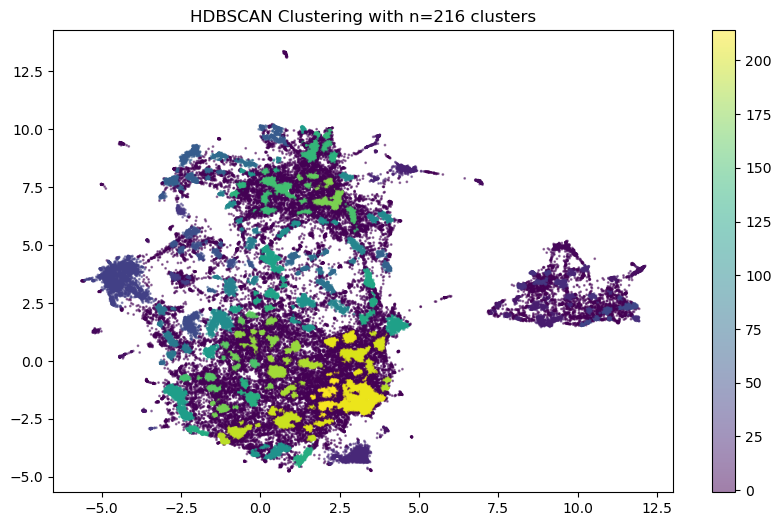

60


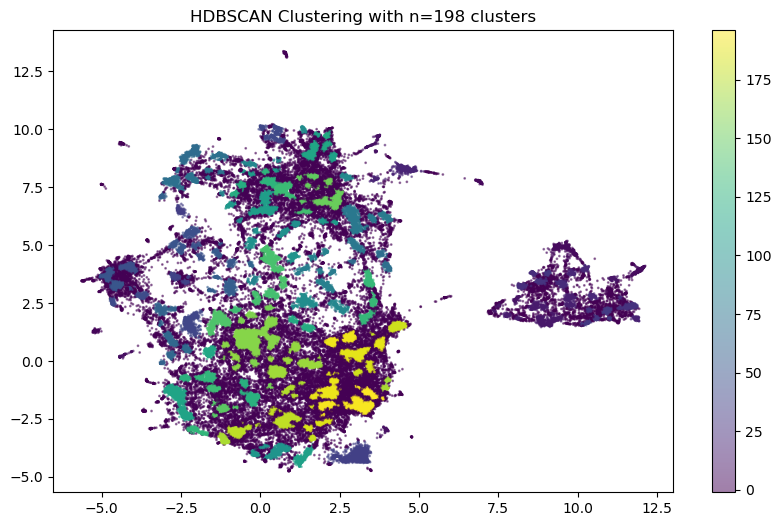

In [14]:
importlib.reload(cu)
min_samples = np.arange(10, 70, 10)
min_cluster_size = np.arange(10, 1000, 20)

for i in min_samples:
    print(i)
    hdbscan_labels = cu.hdbscan_cluster(coordinates, 
                                        min_cluster_size=20, min_samples=i, 
                                        gen_min_span_tree=False, plot=1)
# hdbscan_labels = cu.hdbscan_cluster(coordinates, 
#                                     min_cluster_size=20, min_samples=100, 
#                                     gen_min_span_tree=True, plot=1)

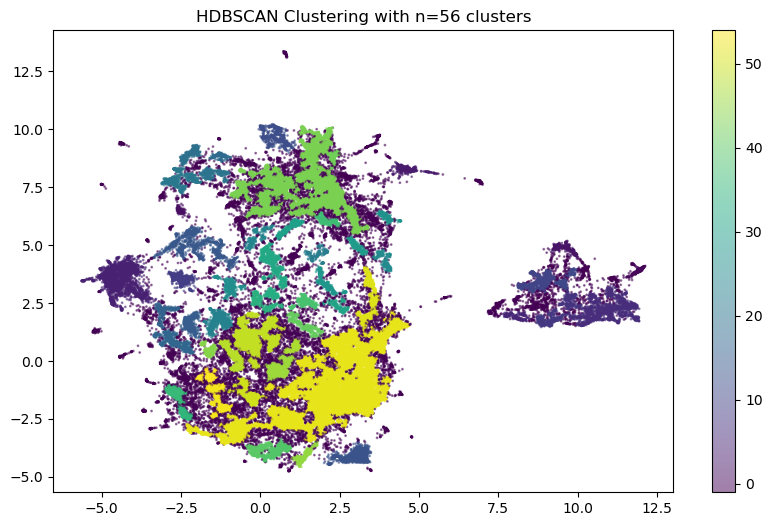

In [18]:
importlib.reload(cu)
hdbscan_labels = cu.hdbscan_cluster(coordinates, 
                                    min_cluster_size=250, min_samples=20, 
                                    gen_min_span_tree=True, plot=1)

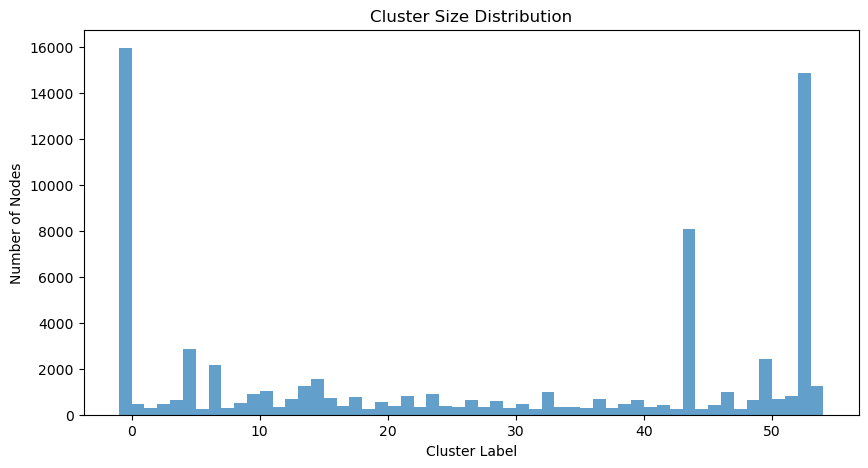

In [20]:
# plot cluster size distribution

plt.figure(figsize=(10, 5))
plt.hist(hdbscan_labels, bins=np.arange(-1, hdbscan_labels.max()+1, 1), alpha=0.7)
plt.title("Cluster Size Distribution")
plt.xlabel("Cluster Label")
plt.ylabel("Number of Nodes")
# plt.ylim(0, 3000)
plt.show()

### K-means clustering

Let's start with a random number of clusters... (use same # found from hdbscan)

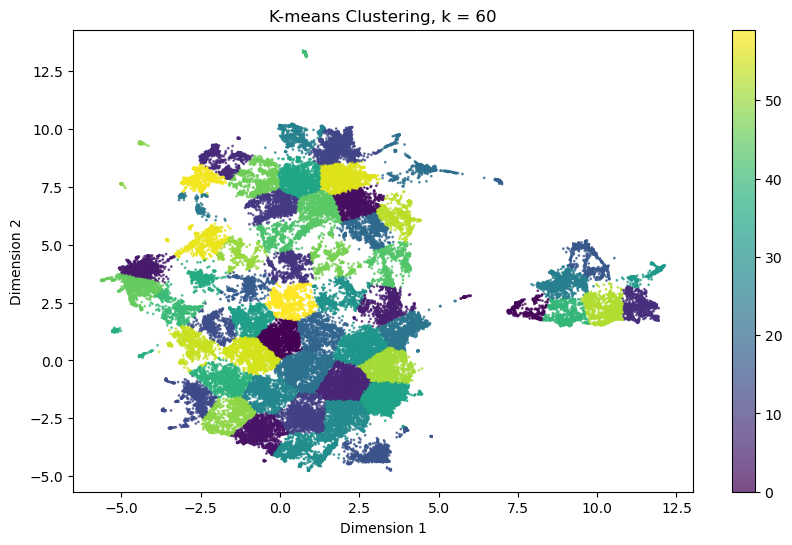

In [4]:
# Plot the clusters
importlib.reload(cu)
kmeans_labels = cu.kmeans_cluster(coordinates, n_clusters=60, plot=1)

## Stats

In [5]:
df = pd.read_csv(
            proj_dir + "/dataset/pubmed_20241121_working_memory.raw",
            sep="\t"
        )

df.head()

pmid                                              title  \
0   710  Effect of two weeks' treatment with thioridazi...   
1  2563  EEG sleep studies of insomniacs under flunitra...   
2  2812  Alcohol and backward masking of visual informa...   
3  2813  Recovery of verbal short-term memory in alcoho...   
4  6497  Effect of counterconditioning on test anxiety ...   

                             journal  year  \
0                Psychopharmacologia  1975   
1   International pharmacopsychiatry  1975   
2      Journal of studies on alcohol  1976   
3      Journal of studies on alcohol  1976   
4  Journal of educational psychology  1976   

                                            abstract  \
0  Forty paid healthy male students participated ...   
1  This study investigates the effect of flunitra...   
2  Alcohol increased the time necessary to transf...   
3  When given a short-term memory distractor test...   
4                                                NaN   

                                          mesh_terms  \
0  Adult;Animals;Anti-Anxiety Agents;Bromazepam;C...   
1  Adult;Anti-Anxiety Agents;Dreams;Electroenceph...   
2  Adult;Dose-Response Relationship, Drug;Ethanol...   
3  Adult;Age Factors;Aged;Alcohol Amnestic Disord...   
4  Achievement;Adolescent;Anxiety;Behavior Therap...   

                                         mesh_topics  
0  pharmacology;blood;pharmacology;pharmacology;p...  
1  therapeutic use;drug effects;adverse effects;p...  
2             pharmacology;drug effects;drug effects  
3  complications;complications;drug effects;drug ...  
4                                                NaN

In [6]:
importlib.reload(db)
points_df = db._get_points_df(None,
                  path_tsv = proj_dir + "/dataset/pubmed_20241121_working_memory.raw",
                  delimiter = "\t",
                  points = coordinates,
                  )
points_df.head()

* loaded df
* merged embds to df


pmid                                         mesh_terms  \
0   710  Adult;Animals;Anti-Anxiety Agents;Bromazepam;C...   
1  2563  Adult;Anti-Anxiety Agents;Dreams;Electroenceph...   
2  2812  Adult;Dose-Response Relationship, Drug;Ethanol...   
3  2813  Adult;Age Factors;Aged;Alcohol Amnestic Disord...   
4  6497  Achievement;Adolescent;Anxiety;Behavior Therap...   

                                         mesh_topics         x         y  
0  pharmacology;blood;pharmacology;pharmacology;p... -0.585594  7.589080  
1  therapeutic use;drug effects;adverse effects;p... -0.686546  7.673503  
2             pharmacology;drug effects;drug effects -3.049032  7.700844  
3  complications;complications;drug effects;drug ... -3.037893  7.590261  
4                                                NaN -1.976663  0.112361

### kmeans

In [7]:
print(np.unique(kmeans_labels))
print(len(kmeans_labels))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
73763


In [9]:
from collections import defaultdict

cluster_terms = defaultdict(list)
for index, label in enumerate(kmeans_labels):
    # skip if cluster -1 (noise)
    if label == -1:
        continue

    mesh_terms = points_df.iloc[index, points_df.columns.get_loc("mesh_terms")]

    # Check if the 'mesh_terms' is NaN or missing
    if pd.isna(mesh_terms):
        continue  # Skip this iteration if mesh_terms is NaN

    # Otherwise, split the terms and add them to the cluster_terms
    cluster_terms[label].extend(
        [t for t in mesh_terms.split(";")]
    )

In [ ]:
# Step 1: Extract unique values across all lists
unique_values = set(value for values in cluster_terms.values() for value in values)

# Step 2: Create a mapping of each unique value to an index
value_to_index = {value: idx for idx, value in enumerate(sorted(unique_values))}

# Step 3: Update the original dictionary to replace values with their indices
indexed_dict = {key: [value_to_index[value] for value in values] for key, values in cluster_terms.items()}

{46: [306, 645, 696, 1539, 2150, 2313, 3423, 3906, 5368, 6587, 6794, 8185, 9314, 9489, 9712, 10994, 11318, 306, 696, 3371, 3603, 4111, 4237, 5368, 6587, 6794, 7029, 10525, 10535, 10538, 10540, 12033, 306, 696, 993, 2313, 3362, 4111, 4221, 5368, 6587, 6794, 7207, 7722, 8711, 9599, 11191, 306, 696, 2130, 3405, 3906, 5368, 6231, 6786, 6794, 7780, 8129, 11191, 11381, 306, 1357, 4111, 5368, 6231, 6388, 6587, 6786, 6794, 7029, 553, 645, 3291, 3358, 3716, 3753, 4111, 4952, 6231, 6532, 6587, 6794, 7201, 9849, 306, 696, 2313, 3160, 5368, 6435, 6786, 6794, 6827, 7029, 8367, 8711, 8967, 306, 596, 3160, 4111, 5368, 6587, 6786, 6794, 7201, 7207, 9274, 9599, 11381, 306, 5368, 6587, 6794, 6827, 7414, 306, 517, 2313, 3164, 3362, 3405, 3906, 4111, 4221, 5368, 5474, 6111, 6231, 6587, 6794, 6949, 306, 517, 2313, 3164, 3362, 3906, 4111, 5368, 6587, 6794, 6949, 7207, 8711, 306, 3160, 3405, 3673, 4111, 5368, 6587, 6786, 6794, 6827, 8650, 9970, 10229, 10230, 165, 306, 517, 737, 1030, 1401, 3118, 3603, 4111, 

In [11]:
# get the top 10 terms across clusters

# Step 4: Count the frequency of each index across all lists
term_counts = np.zeros(len(value_to_index))
for values in indexed_dict.values():
    for value in values:
        term_counts[value] += 1
        

In [13]:
# get the top term

# Step 5: Get the top 10 terms
top_indices = np.argsort(term_counts)[::-1][:10]
top_terms = {idx: term for term, idx in value_to_index.items() if idx in top_indices}
print(top_terms)

{306: 'Adult', 645: 'Animals', 2376: 'Cognition', 4111: 'Female', 5368: 'Humans', 6587: 'Male', 6794: 'Memory, Short-Term', 7029: 'Middle Aged', 7653: 'Neuropsychological Tests', 12199: 'Young Adult'}


In [14]:
print(len(indexed_dict[0]))
print(len(np.unique(indexed_dict[0])))

19355
1343


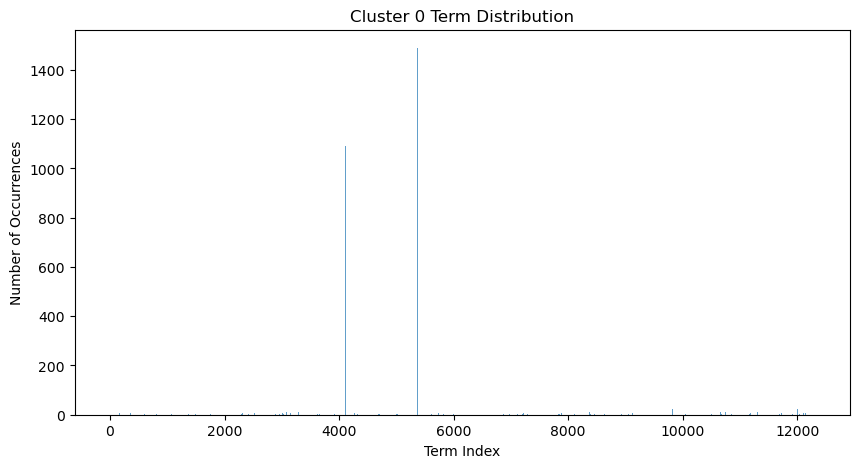

In [23]:
# plot the first key in the dictionary
plt.figure(figsize=(10, 5))
plt.hist(indexed_dict[0], bins=np.arange(0, len(value_to_index), 1), alpha=0.7)
plt.title("Cluster 0 Term Distribution")
plt.xlabel("Term Index")
plt.ylabel("Number of Occurrences")
# plt.ylim(0, 125)
plt.show()

In [16]:
# index to value
index_to_value = {idx: value for value, idx in value_to_index.items()}

In [17]:
# get the some top terms for each cluster
for clus in indexed_dict:
    term_idx = indexed_dict[clus]
    term_freq = np.bincount(term_idx)
    most_freq_idx = np.argsort(term_freq)[-30:-25]
    most_freq_term = [index_to_value[idx] for idx in most_freq_idx]
    print(f"Cluster {clus}: {most_freq_term} ({term_freq[most_freq_idx]} occurrences)")

Cluster 46: ['Receptors, Nicotinic', 'Adolescent', 'Nicotinic Agonists', 'Behavior, Animal', 'Nicotine'] ([ 97  99  99 101 108] occurrences)
Cluster 58: ['Pregnancy', 'Aged', 'Alcoholic Intoxication', 'Cocaine-Related Disorders', 'Case-Control Studies'] ([50 53 61 61 66] occurrences)
Cluster 54: ['Cognition Disorders', 'Stress, Psychological', 'Memory Disorders', 'Magnetic Resonance Imaging', 'Treatment Outcome'] ([60 61 62 65 65] occurrences)
Cluster 20: ['Retention, Psychology', 'Discrimination Learning', 'Neurons', 'Synapses', 'Long-Term Potentiation'] ([71 71 75 75 77] occurrences)
Cluster 15: ['Discrimination, Psychological', 'Memory Disorders', 'Practice, Psychological', 'Cues', 'Aged'] ([73 75 79 81 82] occurrences)
Cluster 30: ['Reaction Time', 'Temporal Lobe', 'Mental Recall', 'Hippocampus', 'Time Factors'] ([89 93 97 98 99] occurrences)
Cluster 3: ['Mental Recall', 'Executive Function', 'Reaction Time', 'Memory', 'Semantics'] ([113 115 118 124 132] occurrences)
Cluster 45: ['

In [18]:
from scipy.stats import mannwhitneyu

In [19]:
# perform Mann-Whitney U tests for all combos of clusters

# Create a list of cluster labels
cluster_labels = list(indexed_dict.keys())

p_values = np.ones((len(cluster_labels), len(cluster_labels)))

for i, label1 in enumerate(cluster_labels):
    for j, label2 in enumerate(cluster_labels):
        if i >= j:
            continue

        # Perform Mann-Whitney U test (non-parametric test)
        u_stat, p_value = mannwhitneyu(indexed_dict[label1], indexed_dict[label2])
        p_values[i, j] = p_value
        p_values[j, i] = p_value


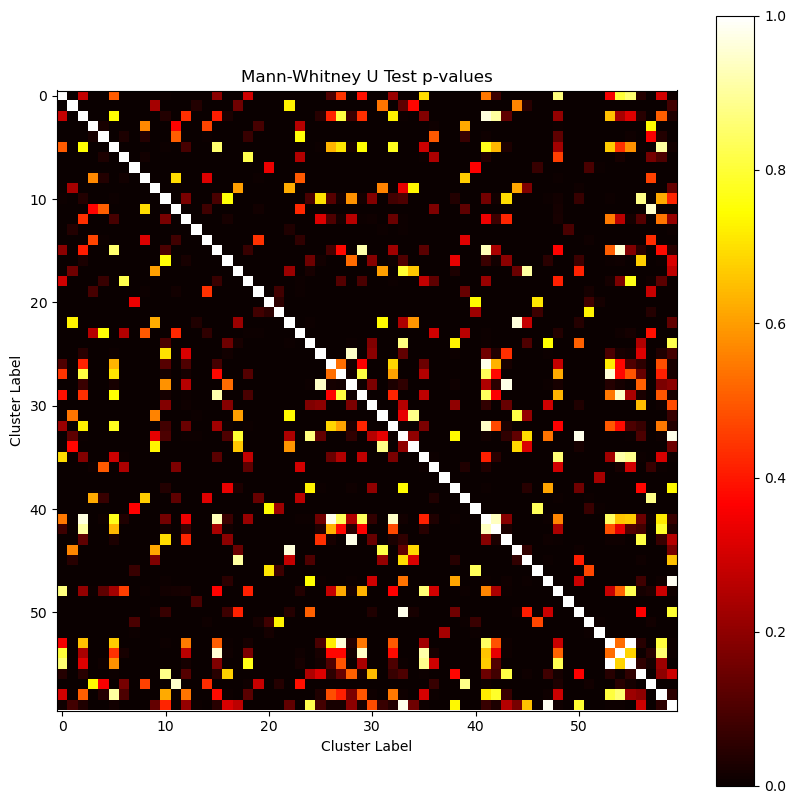

In [20]:
plt.figure(figsize=(10, 10))
plt.imshow(p_values, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Mann-Whitney U Test p-values")
plt.xlabel("Cluster Label")
plt.ylabel("Cluster Label")
plt.show()

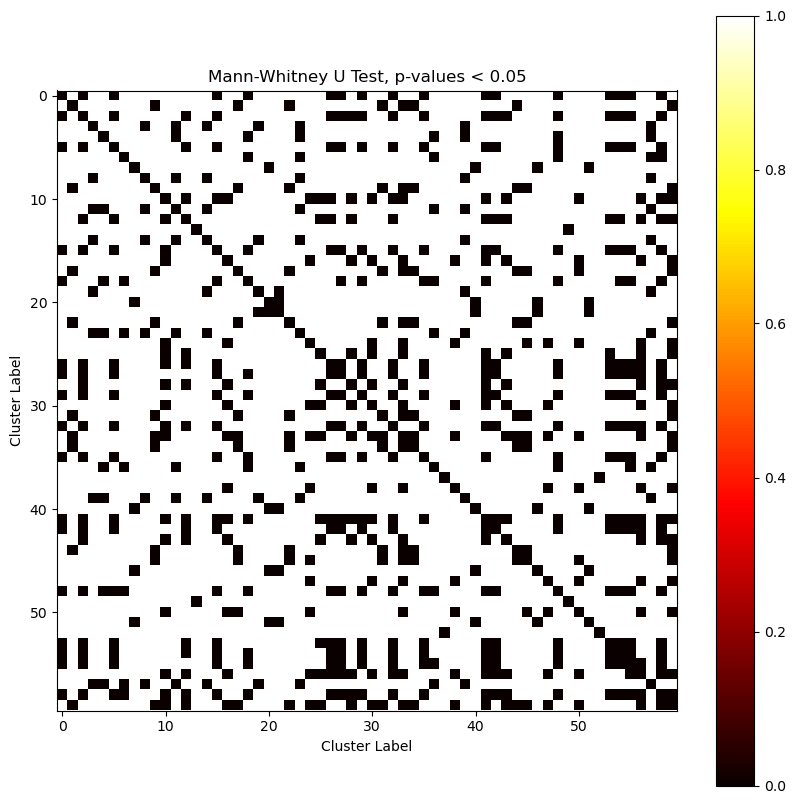

In [21]:
p_values_sig = np.where(p_values < 0.05, 1, 0)

plt.figure(figsize=(10, 10))
plt.imshow(p_values_sig, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Mann-Whitney U Test, p-values < 0.05")
plt.xlabel("Cluster Label")
plt.ylabel("Cluster Label")
plt.show()

In [22]:
# percentage of significant p-values
np.sum(p_values_sig) / (len(cluster_labels) ** 2)

0.7966666666666666